- GAN : 진자와 가짜를 구별할수 없도록 정교한 가짜를 만드는 - - - 생성자를 학습하는 알고리즘
- 감별자 : 진짜와 가짜를 구별하도록 학습
- 생성자 : 감별자를 속이도록 학습
- 특징 공간상에서 두 특징의 평균값은 두 특징의 중간 정도로 표현
- 가중치 초기화 : 일반적으로 특정한 확률 분포를 따르도록 초기화

In [1]:
!unzip /content/drive/MyDrive/얼굴생성/archive.zip -d './GAN/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./GAN/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: ./GAN/img_align_celeba/img_align_celeba/197618.jpg  
  inflating: ./GAN/img_align_celeba/img_

In [10]:
import glob
imgs = glob.glob('/content/GAN/img_align_celeba/img_align_celeba/*.jpg')

In [18]:
imgs[:6]

['/content/GAN/img_align_celeba/img_align_celeba/108597.jpg',
 '/content/GAN/img_align_celeba/img_align_celeba/043010.jpg',
 '/content/GAN/img_align_celeba/img_align_celeba/037950.jpg',
 '/content/GAN/img_align_celeba/img_align_celeba/159850.jpg',
 '/content/GAN/img_align_celeba/img_align_celeba/130372.jpg',
 '/content/GAN/img_align_celeba/img_align_celeba/096280.jpg']

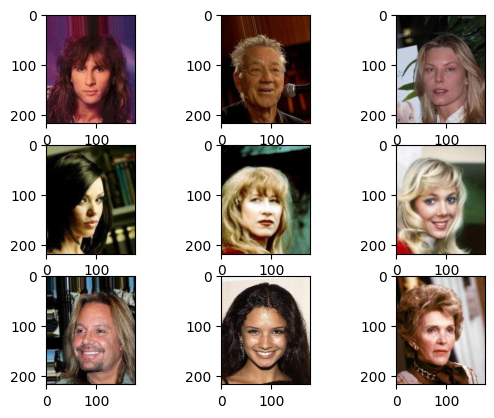

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(imgs[i])
  plt.imshow(img)
plt.show()

In [19]:
# 학습용 데이터 셋
DATASET_DIR = "/content/GAN/img_align_celeba/img_align_celeba"
IMG_SIZE = 64

In [20]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Adam

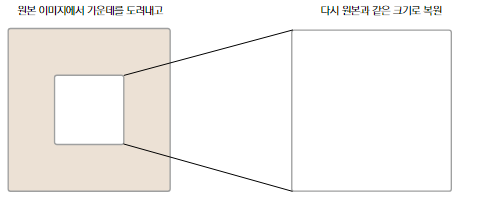

In [42]:
class CustomData(Dataset):
  def __init__(self,data_dir):
    self.img_paths = sorted(glob.glob(data_dir + '/*.jpg'))
    self.transforms = transforms.Compose([
        transforms.Resize( [IMG_SIZE,IMG_SIZE] ),
        ToTensor(),
        transforms.CenterCrop(IMG_SIZE),
        transforms.Normalize([0.5],[0.5])
    ])
  def __len__(self):
    return len(self.img_paths)
  def __getitem__(self, index):
    img = Image.open(self.img_paths[index])
    tensor_img =  self.transforms(img)
    return tensor_img

In [43]:
dataset = CustomData(DATASET_DIR)

In [45]:
loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [46]:
# loader 의 데이터를 한 배치
img_sample =  next(iter(loader))
img_sample.shape


torch.Size([128, 3, 64, 64])

생성자 정의

In [ ]:
# 업샘플링층과 배치정규화층을 쌓아서 만들고.. 입력은 100차원의벡터

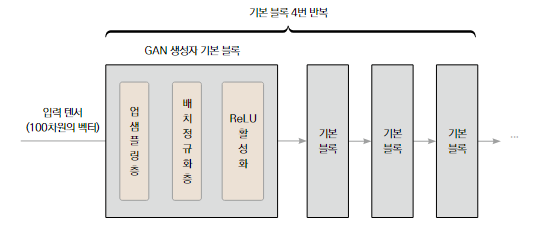

In [73]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(100,512,kernel_size=4, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
        # 원점에 대해 대칭적이므로 생성자가 어두운색과 밝은색을 대칭적으로 학습할수 있도록
        nn.Tanh()
    )
  def forward(self,x):
    return self.gen(x)

감별자 - 기존 cnn 과 유사하게 구현

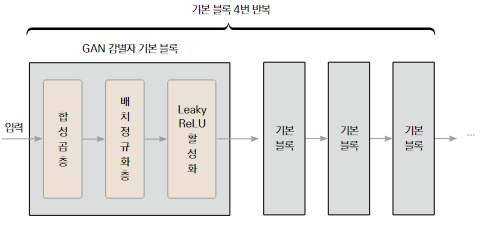

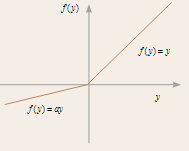

In [74]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        # 이진 분류층이 되므로
        nn.Conv2d(512,1,kernel_size=4),
        nn.Sigmoid()
    )
  def forward(self,x):
      return self.disc(x)


- 가중치 초기화
  - 합성곱층의 가중치는 평균0, 표준편차 0.02인 정규분포를 따르도록 설정
  - 배치정규화층은 평균이 1.0 표준편차 0.02 인 정규분포를 따르도록 설정
  - 배치 정규화층의 편향은 0으로 설정

- 평균이 0, 표준편차가 0.02가 되로고 설정하는 것이 가장 잘 학습된다고 알려져있음  
  

In [75]:
def weights_init(m):
  # 층의 종류 추출
  classname =  m.__class__.__name__
  if classname.find('Conv') != -1:
    # 합성곱층 초기화
    nn.init.normal_(m.weight.data,0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    # 배치 정규화층 초기화
    nn.init.normal_(m.weight.data,1.0, 0.02)  # 정규분포를 따르도록 가중치를 초기화
    nn.init.constant_(m.bias.data,0)  # 가중치를 0으로 초기화


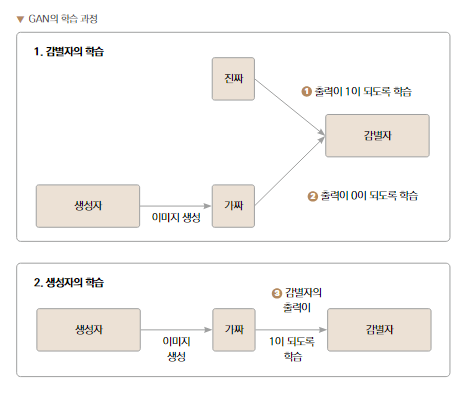

In [76]:
import torch
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
# 생성자 정의
G = Generator().to(device)
# 생성자 가중치 초기화
G.apply(weights_init)

# 감별자정의
D = Discriminator().to(device)
# 감별자 가중치 초기화
D.apply(weights_init)

G_optim = Adam(G.parameters())
D_optim = Adam(D.parameters())

In [83]:
D

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [55]:
# 감별자 학습 : 진짜이미지와 생성자가 만든 이미지 찐짜이미지는 참 가짜이미지는 거짓을 감별자에게 정답으로 알려줘야함
# 배치크기만큼 1을 채워서 진짜 이미지를 인식하도록 정답,  ones_like()
# 가짜이미지를 인식하도록 0으로 채워야함   zeros_like()

In [80]:
for data in loader:
  print(data.shape)
  break

torch.Size([128, 3, 64, 64])


In [91]:
import tqdm
for epoch in range(50):
  iter = tqdm.tqdm(enumerate(loader), total=len(loader))
  for i,data in iter:
    D_optim.zero_grad()
    # 실제이미지에는 1, 생성된 가짜 이미지는 0으로 정답을 설정
    label =  torch.ones_like(data[1],dtype=torch.float32).to(device)
    label_fake = torch.zeros_like(data[1],dtype=torch.float32).to(device)
    # 실제 이미지를 감별자에 입력
    # print(data[0].unsqueeze(dim=0).shape)

    real = D(data[0].unsqueeze(dim=0).to(device))
    # 실제 이미지에 대한 감별자의 오차 계산
    print()
    print(real, real.shape,label.shape)
    print()
    Dloss_real = nn.BCELoss()(torch.squeeze(real),label)
    Dloss_real.backward()

    # 감별자에 대한 가짜이미지에 대한 오차를 계산
    # 가짜 이미지 생성
    noise = torch.randn(label.shape[0],100,1,1,device=device)
    fake = G(noise)

    # 가짜 이미지를 감별자에게 입력
    output = D(fake.detach())

    # 가짜 이미지에대한 감별자의 오차 계산
    Dloss_fake = nn.BCELoss()(torch.squeeze(output),label_fake)
    Dloss_fake.backward()

    # 감별자의 전체오차를 계산
    Dloss = Dloss_real + Dloss_fake
    D_optim.step()

    # 생성자의 학습
    G_optim.zero_grad()
    output = D(fake)
    Gloss = nn.BCELoss()(torch.squeeze(output),label)
    Gloss.backward()
    G_optim.step()

    iter.set_description(f"epoch:{epoch} iter:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(),"Generator.pth")
torch.save(D.state_dict(),"Discriminator.pth")

  0%|          | 0/1583 [00:00<?, ?it/s]


tensor([[[[0.8005]]]], grad_fn=<SigmoidBackward0>) torch.Size([1, 1, 1, 1]) torch.Size([3, 64, 64])



ValueError: ignored